# Loss Functions

In [3]:
class Loss:
    def __init__(self, L2 = 'False', lamb = 1):
        self.lamb = lamb
        self.L2 = L2
        
class Quadratic(Loss):
    def __init__(self, L2 = 'False', lamb = 1):
        self.lamb = lamb
        self.L2 = L2

class Exponential(Loss):
    def __init__(self, L2 = 'False', lamb = 1):
        self.lamb = lamb
        self.L2 = L2
            
class Hinge(Loss):    
    def __init__(self, L2 = 'False', lamb = 1):
        self.lamb = lamb
        self.L2 = L2

class Smooth_hinge(Loss):  
    def __init__(self, L2 = 'False', lamb = 1):
        self.lamb = lamb
        self.L2 = L2

# Gradient Descent Algorithms

In [1]:
import numpy as np

class BaseOptimizer:
    """ 
    Abstract optimizer base class
    """

    def __init__(self, learning_rate=0.1):
        self.learning_rate = learning_rate
        
    def get_gradients(self, loss, X, y, params):
        
        n = len(y)
        gradient = np.zeros_like(X[0])
        
        if isinstance(loss, Quadratic):
            if loss.L2 == 'False':
                gradient = sum(y[i]*X[i]*(y[i]*X[i].T@params - 1) for i in range(n))
                return 2*gradient/n
            else: return 2*gradient/n + 2*loss.lamb*params/n
            
        elif isinstance(loss, Exponential):
            if loss.L2 == 'False':
                gradient = sum(-np.exp(-X[i].T@params)*X[i] for i in range(n))
                return 2*gradient/n
            else: return 2*gradient/n + 2*loss.lamb*params/n
            
        elif isinstance(loss, Hinge):
            if loss.L2 == 'False':
                gradient = sum(-y[i]*X[i] for i in range(n) if y[i]*X[i].T@params < 1)
                return gradient/n
            else: return gradient/n + 2*loss.lamb*params/n
            
        elif isinstance(loss, Smooth_hinge):
            if loss.L2 == 'False':
                for i in range(n):
                    if y[i]*X[i].T@params <= 0:
                        gradient += -y[i]*X[i]
                    elif y[i]*X[i].T@params < 1:
                        gradient += 2*y[i]*X[i]*(y[i]*X[i].T@params - 1)
                return gradient/n
            else: return gradient/n + 2*loss.lamb*params/n
    
    def get_updates(self, loss, X, y, params):
        raise NotImplementedError


class SGD(BaseOptimizer):
    """ 
    SGD with momentum and nesterov
    """

    def __init__(self, learning_rate=0.01, momentum=0., nesterov=False):
        super(SGD, self).__init__(learning_rate)
        self.momentum = momentum
        self.nesterov = nesterov
        self.velocities = []

    def get_updates(self, loss, X, y, params):
        if not self.velocities:
            self.velocities = [np.zeros_like(p) for p in params]
        if self.nesterov:
            params_for_grad = [v + p for v, p in zip(self.velocities, params)]
        else:
            params_for_grad = params
            
        grads = self.get_gradients(loss, X, y, params_for_grad)

        updates = [self.momentum * v - self.learning_rate * g
                   for v, g in zip(self.velocities, grads)]

        self.velocities = updates

        return updates

    
class Adam(BaseOptimizer):
    """
    Adam optimizer
    """
    def __init__(self, learning_rate_init=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        super().__init__(learning_rate_init)
        self.learning_rate_init = learning_rate_init
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 0
        self.ms = []
        self.vs = []
        

    def get_updates(self, loss, X, y, params):
        
        grads = self.get_gradients(loss, X, y, params)
        
        self.ms = [np.zeros_like(param) for param in params]
        self.vs = [np.zeros_like(param) for param in params]
        
        self.t += 1
        self.ms = [self.beta_1 * m + (1 - self.beta_1) * grad
                   for m, grad in zip(self.ms, grads)]
        self.vs = [self.beta_2 * v + (1 - self.beta_2) * (grad ** 2)
                   for v, grad in zip(self.vs, grads)]
        self.learning_rate = (self.learning_rate_init *
                              np.sqrt(1 - self.beta_2 ** self.t) /
                              (1 - self.beta_1 ** self.t))
        updates = [-self.learning_rate * m / (np.sqrt(v) + self.epsilon)
                   for m, v in zip(self.ms, self.vs)]
        return updates



# Test

## Data Simulation

In [ ]:
beta_true = np.random.normal(5,10,2)
X = np.random.normal(0, 1, (100,2))
eps = np.random.normal(0,1,100)
y = 2*(X @ beta_true + eps > 0)-1
y

## Hinge Loss

In [10]:
loss = Hinge('False', 1)

## Classical Momentum Gradient Descent

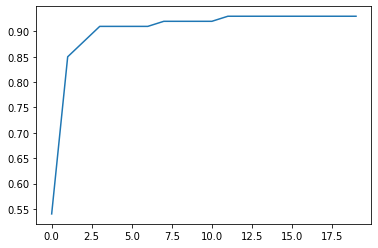

In [11]:
import matplotlib.pyplot as plt

Op = SGD(momentum=0.9,nesterov=False) 
params = np.zeros(2)
true_rate0 = []
T = 1000
while T > 0:
    updates = Op.get_updates(loss, X, y, params)
    params = [p + u for p, u in zip(params, updates)]
    y_new = 2*(X @ params + eps > 0)-1
    if T % 50 == 0:  
        true_rate0.append(sum(y_new == y)/len(y))
    T -= 1
    
plt.plot(true_rate0)

## Nesterov's Gradient Descent

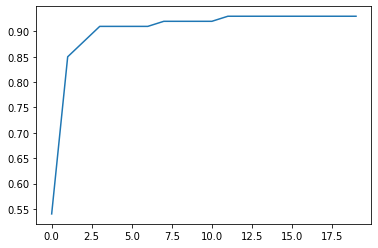

In [12]:
import matplotlib.pyplot as plt
Op = SGD(momentum=0.9,nesterov=True) 
params = np.zeros(2)
true_rate1 = []
T = 1000
while T > 0:
    updates = Op.get_updates(loss, X, y, params)
    params = [p + u for p, u in zip(params, updates)]
    y_new = 2*(X @ params + eps > 0)-1
    if T % 50 == 0:  
        true_rate1.append(sum(y_new == y)/len(y))
    T -= 1
    
plt.plot(true_rate1)

## Stochaostic Gradient Descent

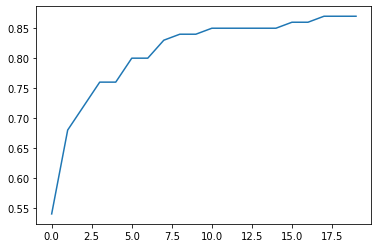

In [13]:
import matplotlib.pyplot as plt
Op = SGD(momentum=0.,nesterov=False)
params = np.zeros(2)
true_rate2 = []
T = 1000
while T > 0:
    updates = Op.get_updates(loss, X, y, params)
    params = [p + u for p, u in zip(params, updates)]
    y_new = 2*(X @ params + eps > 0)-1
    if T % 50 == 0:  
        true_rate2.append(sum(y_new == y)/len(y))
    T -= 1
    
plt.plot(true_rate2)

## Adam Gradient Descent

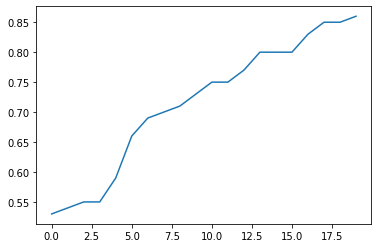

In [14]:
import matplotlib.pyplot as plt
Op = Adam()
params = np.zeros(2)
true_rate3 = []
T = 1000
while T > 0:
    updates = Op.get_updates(loss, X, y, params)
    params = [p + u for p, u in zip(params, updates)]
    y_new = 2*(X @ params + eps > 0)-1
    if T % 50 == 0:  
        true_rate3.append(sum(y_new == y)/len(y))
    T -= 1
    
plt.plot(true_rate3)

## Comparison

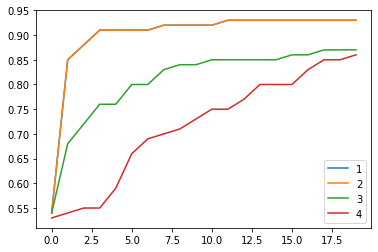

In [15]:
plt.plot(true_rate0)
plt.plot(true_rate1)
plt.plot(true_rate2)
plt.plot(true_rate3)
plt.legend(['1', '2', '3', '4'])

# Reference

Nesterov: https://www.cs.toronto.edu/~fritz/absps/momentum.pdf

Adam: https://arxiv.org/abs/1412.6980